# D2 Paper Implementation: Hierarchical Deep Learning for Arabic Diacritization

This notebook implements a hierarchical deep learning model inspired by the 'Effective Deep Learning Models for Automatic Diacritization of Arabic Text' paper.

## Key Components:
1.  **Hierarchical Architecture:** The model processes text at two levels:
    *   **Word Level:** A Bidirectional LSTM encodes the sequence of words.
    *   **Character Level:** A Bidirectional LSTM encodes the sequence of characters within each word, conditioned on the word embedding.
2.  **Cross-Level Attention:** A mechanism to align character representations with word contexts, allowing the model to focus on relevant parts of the word embedding when predicting diacritics for a specific character.
3.  **Data Processing:**
    *   **Sliding Window:** Long sentences are split into overlapping segments to handle variable lengths and augment data.
    *   **Mappings:** Characters and diacritics are mapped to integer IDs.
4.  **Training:**
    *   **Loss:** Cross-Entropy Loss (ignoring padding).
    *   **Optimization:** Adam optimizer with `ReduceLROnPlateau` scheduler.
    *   **Regularization:** Dropout at multiple layers (Word, Char, Attention) to prevent overfitting.

## Why this approach?
Hierarchical models capture both local morphological features (character-level) and global syntactic context (word-level), which are essential for accurate Arabic diacritization.

In [9]:
# Required Imports

import os
import re
import pickle
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [10]:
# Configuration
# NOTE: Toggle RUNNING_IN_KAGGLE to switch between local and Kaggle paths
# NOTE: All hyperparameters are centralized here for easy experimentation
# NOTE: Initial Values were based on the paper

CONFIG = {
    "RUNNING_IN_KAGGLE": False, 
    "PATHS": {
        "KAGGLE_BASE": "/kaggle/input/tashkeel",
        "LOCAL_BASE": "../data",
        "OUTPUT_DIR": "artifacts"
    },
    # NOTE: Training hyperparameters
    "TRAIN": {
        "BATCH_SIZE": 128,                   # Paper uses 128, reduced for memory
        "LEARNING_RATE": 0.002,              # Initial learning rate (Adam optimizer)
        "NUM_EPOCHS": 2,                    # Max epochs before early stopping
        "EARLY_STOPPING_PATIENCE": 3,        # Stop if no improvement for 3 epochs
        "LR_REDUCE_FACTOR": 0.5,             # Reduce LR by half on plateau
        "LR_PATIENCE": 1                     # Reduce LR if no improvement for 1 epoch
    },
    # NOTE: Dataset parameters
    # Ts = max words per segment, Tw = max chars per word
    "DATA": {
        "MAX_WORDS": 10,                     # Ts: Paper uses 10 for train, 20 for eval
        "STRIDE": 5,                         # Overlap between segments (paper uses 1 for train)
        "MAX_CHARS_PER_WORD": 13,            # Tw: Max characters allowed per word
        "MIN_WORD_FREQ": 2,                  # Minimum word frequency for vocabulary
        "SUBSET_SIZE": 1000                  # Number of lines to use (None for full data)
    },
    # NOTE: Model architecture hyperparameters
    "MODEL": {
        # Word-level encoder
        "WORD_EMB_DIM": 128,                 # Word embedding dimension
        "WORD_HIDDEN_DIM": 256,              # Bi-LSTM hidden units (paper: 256)
        "WORD_LSTM_LAYERS": 2,               # Number of stacked Bi-LSTM layers (paper: 2)
        
        # Character-level encoder
        "CHAR_EMB_DIM": 32,                  # Character embedding dimension (paper: 32)
        "CHAR_HIDDEN_DIM": 512,              # Bi-LSTM hidden units (paper: 512)
        "CHAR_LSTM_LAYERS": 3,               # Number of stacked Bi-LSTM layers
        
        # Regularization
        "DROPOUT": 0.25,                     # Vertical and recurrent dropout (paper: 0.25)
        "WORD_DROPOUT": 0.2,                 # Sentence dropout probability (paper: 0.2)
        "INPUT_DROPOUT": 0.2                 # Dropout on char encoder input (paper: 0.2)
    }
}

# Determine Base Path
if CONFIG["RUNNING_IN_KAGGLE"]:
    BASE_PATH = CONFIG["PATHS"]["KAGGLE_BASE"]
    print("Running in Kaggle mode.")
else:
    BASE_PATH = CONFIG["PATHS"]["LOCAL_BASE"]
    print("Running in Local mode.")

Running in Local mode.


In [11]:
# Device Configuration and Data Paths
# NOTE: Setup paths based on CONFIG and load pre-computed character/diacritic mappings

# NOTE: Use GPU if available for faster training
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# NOTE: Setup paths using BASE_PATH from CONFIG
DATA_DIR = BASE_PATH
UTILS_DIR = os.path.join(BASE_PATH, "utils") if not CONFIG["RUNNING_IN_KAGGLE"] else BASE_PATH
TRAIN_FILE = os.path.join(DATA_DIR, "train.txt")
VAL_FILE = os.path.join(DATA_DIR, "val.txt")
RESUME_PATH = "d2_model_latest.pth"
ARTIFACTS_DIR = CONFIG["PATHS"]["OUTPUT_DIR"]
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# NOTE: Load pre-computed mappings from pickle files
print("Loading character and diacritic mappings...")
with open(os.path.join(UTILS_DIR, "arabic_letters.pkl"), "rb") as f:
    ARABIC_LETTERS = pickle.load(f)
with open(os.path.join(UTILS_DIR, "diacritics.pkl"), "rb") as f:
    DIACRITICS = pickle.load(f)
with open(os.path.join(UTILS_DIR, "diacritic2id.pkl"), "rb") as f:
    DIACRITIC2ID = pickle.load(f)

# NOTE: Build character-to-ID mapping with special tokens
CHAR2ID = {char: idx for idx, char in enumerate(sorted(ARABIC_LETTERS))}
CHAR2ID["<PAD>"] = len(CHAR2ID)  # Padding token
CHAR2ID["<UNK>"] = len(CHAR2ID)  # Unknown character token

# NOTE: Inverse mappings for decoding predictions
ID2CHAR = {idx: char for char, idx in CHAR2ID.items()}
ID2DIACRITIC = {idx: dia for dia, idx in DIACRITIC2ID.items()}

# NOTE: Special indices for loss computation
PAD_ID = CHAR2ID["<PAD>"]
UNK_ID = CHAR2ID["<UNK>"]
DIA_IGNORE_INDEX = -100  # PyTorch CrossEntropyLoss ignores this index

print(f"Loaded {len(ARABIC_LETTERS)} Arabic letters")
print(f"Loaded {len(DIACRITICS)} diacritic types")
print(f"Character vocabulary size: {len(CHAR2ID)}")
print(f"Number of diacritic classes: {len(DIACRITIC2ID)}")

Using device: cuda
Loading character and diacritic mappings...
Loaded 36 Arabic letters
Loaded 8 diacritic types
Character vocabulary size: 38
Number of diacritic classes: 15


## Data Preparation and Mappings

### Character and Diacritic Mappings

Arabic text consists of:
1. **Base characters** (consonants and long vowels) - the visible letters
2. **Diacritics** - small marks above/below letters indicating short vowels and gemination

The diacritics fall into 4 categories (see Table 2 in paper):
- **Ḥarakāt** (short vowels): fatḥah (a), kasrah (i), ḍammah (u)
- **Tanwīn** (nunation): fatḥatain (an), kasratain (in), ḍammatain (un)
- **Shaddah** (gemination): indicates consonant doubling
- **Sukūn**: indicates no vowel after the consonant

Combined, there are **15 valid diacritic classes** (including "no diacritic").

## Dataset and Data Loading

### Sliding Window Approach

As described in Section 3.3.1 of the paper:

> *"We use a sliding context window of size $T_s$ on each sentence. A given sentence is split into several overlapping segments each of which is given separately to the model during training."*

**Key parameters:**
- `max_words` ($T_s$): Maximum words per segment
- `stride`: Step size between segments (overlap = max_words - stride)

**Benefits:**
1. Handles variable-length sentences uniformly
2. Augments training data through overlapping segments
3. Local context is often sufficient for correct inference

### Voting Mechanism (Inference)
During inference, the same character may appear in multiple overlapping segments with potentially different predictions. The final diacritic is chosen by **majority voting**.

In [12]:
# Data Processing Helper Functions
# NOTE: These functions handle the separation of Arabic text into base characters and diacritics

def extract_chars_and_diacritics(word):
    """
    Separates an Arabic word into base characters and their corresponding diacritics.
    
    NOTE: Each base character can have 0, 1, or 2 diacritics following it.
    For example, a character might have both shaddah (gemination) and a vowel.
    Combined diacritics are looked up in DIACRITIC2ID (15 possible classes).
    
    Returns:
        chars: List of base Arabic characters
        diacritics: List of diacritic IDs (mapped to one of 15 classes)
    """
    chars = []
    diacritics = []
    
    i = 0
    while i < len(word):
        char = word[i]
        
        # NOTE: Skip if this position is itself a diacritic (shouldn't happen at start)
        if char in DIACRITICS:
            i += 1
            continue
            
        chars.append(char)
        
        # NOTE: Collect all diacritics following the current character
        current_diacritics = []
        j = i + 1
        while j < len(word) and word[j] in DIACRITICS:
            current_diacritics.append(word[j])
            j += 1
            
        # NOTE: Map combined diacritics to a single ID (one of 15 classes)
        if not current_diacritics:
            dia_id = DIACRITIC2ID['']  # No diacritic class
        else:
            combined = "".join(current_diacritics)
            if combined in DIACRITIC2ID:
                dia_id = DIACRITIC2ID[combined]
            else:
                # NOTE: Fallback to first diacritic if combination not found
                if current_diacritics[0] in DIACRITIC2ID:
                     dia_id = DIACRITIC2ID[current_diacritics[0]]
                else:
                     dia_id = DIACRITIC2ID['']
        
        diacritics.append(dia_id)
        i = j
        
    return chars, diacritics


def build_vocab(file_path, min_freq=2):
    """
    Builds word vocabulary from training data.
    
    NOTE: Words appearing fewer than min_freq times are mapped to <UNK>.
    This reduces vocabulary size and improves generalization.
    """
    print("Building Vocabulary...")
    word_counts = Counter()
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line: continue
            words = line.split()
            for word in words:
                # NOTE: Remove diacritics to get the undiacritized form
                undiacritized_word = "".join([c for c in word if c not in DIACRITICS])
                word_counts[undiacritized_word] += 1
    
    valid_words = [w for w, c in word_counts.items() if c >= min_freq]
    
    WORD2ID = {word: idx for idx, word in enumerate(valid_words)}
    WORD2ID["<PAD>"] = len(WORD2ID)
    WORD2ID["<UNK>"] = len(WORD2ID)
    
    print(f"Vocab size: {len(WORD2ID)}")
    return WORD2ID


class HierarchicalArabicDataset(Dataset):
    """
    PyTorch Dataset for hierarchical Arabic diacritization.
    
    NOTE: Implements the sliding window approach from Section 3.3.1 of the paper.
    Sentences are split into overlapping segments of max_words each.
    
    Key design choice: Small segment size (Ts=10-20) stabilizes training.
    """
    def __init__(self, file_path, word2id, char2id, diacritic2id, config):
        self.word2id = word2id
        self.char2id = char2id
        self.diacritic2id = diacritic2id
        self.segments = []
        
        # NOTE: Extract dataset parameters from config
        max_words = config["DATA"]["MAX_WORDS"]
        stride = config["DATA"]["STRIDE"]
        subset_size = config["DATA"].get("SUBSET_SIZE", None)
        
        print(f"Loading and segmenting data from {file_path}...")
        print(f"  max_words={max_words}, stride={stride}")
        
        with open(file_path, "r", encoding="utf-8") as f:
            lines = f.readlines()
            # NOTE: Optionally limit data size for faster experimentation
            if subset_size is not None:
                lines = lines[:subset_size]
            
            for line in lines:
                line = line.strip()
                if not line: continue
                words = line.split()
                
                # NOTE: Sliding window with configurable stride
                # overlap = max_words - stride
                for i in range(0, len(words), stride):
                    segment = words[i : i + max_words]
                    if not segment: continue
                    self.segments.append(segment)
                    
        print(f"Total segments: {len(self.segments)}")

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        segment = self.segments[idx]
        
        word_ids = []
        char_seqs = []
        dia_seqs = []
        
        for word in segment:
            chars, dias = extract_chars_and_diacritics(word)
            undiacritized_word = "".join(chars)
            
            # NOTE: Map word to ID (unknown words → <UNK>)
            word_id = self.word2id.get(undiacritized_word, self.word2id["<UNK>"])
            word_ids.append(word_id)
            
            # NOTE: Map each character to ID
            char_ids = [self.char2id.get(c, self.char2id["<UNK>"]) for c in chars]
            char_seqs.append(char_ids)
            dia_seqs.append(dias)
            
        return word_ids, char_seqs, dia_seqs


def collate_fn(batch):
    """
    Custom collate function for batching variable-length sequences.
    
    NOTE: Pads sequences to the maximum length in the batch:
    - Words are padded to max_Ts (max words in any segment in batch)
    - Characters are padded to max_Tw (max chars in any word in batch)
    - Diacritics use DIA_IGNORE_INDEX (-100) for padding (ignored in loss)
    """
    batch_word_ids = [item[0] for item in batch]
    batch_char_seqs = [item[1] for item in batch]
    batch_dia_seqs = [item[2] for item in batch]
    
    # NOTE: Pad word sequences
    max_Ts = max(len(s) for s in batch_word_ids)
    padded_word_ids = torch.full((len(batch), max_Ts), WORD2ID["<PAD>"], dtype=torch.long)
    
    for i, seq in enumerate(batch_word_ids):
        padded_word_ids[i, :len(seq)] = torch.tensor(seq, dtype=torch.long)
    
    # NOTE: Find max character length across all words in batch
    max_Tw = 0
    for seqs in batch_char_seqs:
        for chars in seqs:
            max_Tw = max(max_Tw, len(chars))
            
    # NOTE: Pad character and diacritic sequences
    padded_char_seqs = torch.full((len(batch), max_Ts, max_Tw), CHAR2ID["<PAD>"], dtype=torch.long)
    padded_dia_seqs = torch.full((len(batch), max_Ts, max_Tw), DIA_IGNORE_INDEX, dtype=torch.long)
    
    for i, (char_seq_list, dia_seq_list) in enumerate(zip(batch_char_seqs, batch_dia_seqs)):
        for j, (chars, dias) in enumerate(zip(char_seq_list, dia_seq_list)):
            padded_char_seqs[i, j, :len(chars)] = torch.tensor(chars, dtype=torch.long)
            padded_dia_seqs[i, j, :len(dias)] = torch.tensor(dias, dtype=torch.long)
            
    return padded_word_ids, padded_char_seqs, padded_dia_seqs

## Model Architecture: Two-Level Diacritizer (D2)

Based on the paper

### Key Insight: Hierarchical Processing

Traditional character-based models process entire sentences character by character, leading to sequence lengths of $O(T_s \cdot T_w)$ where:
- $T_s$ = number of words in a sentence
- $T_w$ = number of characters per word

The D2 architecture **separates word-level and character-level processing**, reducing complexity to $O(T_s + T_w)$ — enabling significantly faster training and inference.

### Architecture Components:

1. **Word Encoder (`WordEncoder`)**
   - Takes undiacritized word embeddings as input
   - Uses stacked Bidirectional LSTMs to capture sentence-level context
   - Output: Contextual word representations $f(w)_i$ for each word
   - Implements **Sentence Dropout**: Randomly zeros out word embeddings during training to improve generalization

2. **Character Encoder (`CharEncoder`)**
   - Processes characters within each word independently
   - Input: Character embeddings concatenated with parent word's context $[c_{i,j}; f(w)_i]$
   - Uses stacked Bidirectional LSTMs
   - Output: Contextual character representations $g_{i,j}$

3. **Cross-Level Attention (`CrossLevelAttention`)**
   - Connects character-level to word-level representations
   - For each character, attends over all **other** words in the sentence (excluding current word)
   - Helps capture long-range syntactic dependencies (e.g., grammatical agreement)
   - Follows the attention formulation from Transforms paper.

4. **Classifier**
   - Combines character features with attention context: $[g_{i,j}; f^*_{i,j}]$
   - Softmax over 15 valid diacritic combinations

### Data Flow:
```
Sentence → [Word Encoder] → Word Contexts
                              ↓
Characters → [Char Encoder (+ Word Context)] → Char Features
                                                    ↓
Word Contexts + Char Features → [Attention] → Attended Context
                                                    ↓
                                 [Classifier] → Diacritic Predictions
```

In [13]:
# Model Architecture

class WordEncoder(nn.Module):
    """
    Word-level encoder using stacked Bidirectional LSTMs.
    
    NOTE: It processes the sequence of words and outputs contextual word representations f(w)_i.
    
    Sentence Dropout (word_dropout): Randomly zeros out word embeddings during training
    to improve generalization
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout, word_dropout=0.0):
        super().__init__()
        # NOTE: Word embeddings - learned representations of undiacritized words
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=WORD2ID["<PAD>"])
        
        # NOTE: Stacked Bi-LSTM captures sentence-level context in both directions
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            num_layers=num_layers,           # Paper uses 2 layers
            bidirectional=True, 
            batch_first=True, 
            dropout=dropout if num_layers > 1 else 0  # Dropout between LSTM layers
        )
        self.dropout = nn.Dropout(dropout)
        self.word_dropout = word_dropout

    def forward(self, x):
        embedded = self.embedding(x)
        
        # NOTE: Sentence Dropout - randomly zero out word embeddings during training
        # This forces the model to rely on other words for context, improving robustness
        if self.training and self.word_dropout > 0:
            mask = (torch.rand(x.shape, device=x.device) > self.word_dropout).float().unsqueeze(-1)
            embedded = embedded * mask
        
        output, _ = self.lstm(embedded)
        return output  # Shape: (Batch, Ts, hidden_dim * 2)


class CharEncoder(nn.Module):
    """
    Character-level encoder using stacked Bidirectional LSTMs.
    
    NOTE: For each word, it processes the character sequence conditioned on the word context.
    
    Key innovation: Character-level recurrence is INDEPENDENT for each word,
    enabling parallel processing and reducing complexity from O(Ts*Tw) to O(Ts + Tw).
    """
    def __init__(self, char_vocab_size, char_embedding_dim, word_hidden_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        # NOTE: Character embeddings - 32-dimensional as specified in paper
        self.embedding = nn.Embedding(char_vocab_size, char_embedding_dim, padding_idx=CHAR2ID["<PAD>"])
        
        # NOTE: Input to Char LSTM = char embedding + word context (concatenated)
        # This is the key connection between the two levels: [c_{i,j}; f(w)_i]
        input_dim = char_embedding_dim + word_hidden_dim * 2  # *2 for bidirectional
        
        self.lstm = nn.LSTM(
            input_dim, 
            hidden_dim, 
            num_layers=num_layers,           # Paper uses 3 layers
            bidirectional=True, 
            batch_first=True, 
            dropout=dropout if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, char_seqs, word_contexts):
        batch_size, Ts, Tw = char_seqs.size()
        
        # NOTE: Flatten to process all words in parallel
        flat_char_seqs = char_seqs.reshape(-1, Tw)  # (Batch * Ts, Tw)
        embedded = self.embedding(flat_char_seqs)
        
        # NOTE: Expand word context to match each character in the word
        flat_word_contexts = word_contexts.reshape(-1, word_contexts.size(-1))
        expanded_contexts = flat_word_contexts.unsqueeze(1).expand(-1, Tw, -1)
        
        # NOTE: Concatenate character embedding with word context: [c_{i,j}; f(w)_i]
        combined_input = torch.cat([embedded, expanded_contexts], dim=2)
        
        output, _ = self.lstm(combined_input)
        output = output.reshape(batch_size, Ts, Tw, -1)  # (Batch, Ts, Tw, hidden*2)
        return output


class CrossLevelAttention(nn.Module):
    """
    Cross-level attention module connecting character and word representations.
    
    NOTE: For each character, attends over word-level encodings (EXCLUDING the current word)
    to capture long-range syntactic dependencies.
    
    Uses scaled dot-product attention
    Key insight: Masking the current word forces the model to learn grammatical
    dependencies from other words (e.g., case agreement from prepositions).
    """
    def __init__(self, query_dim, key_dim, value_dim):
        super().__init__()
        # NOTE: Separate projections for Query, Key, Value as in Transformer attention
        self.W_Q = nn.Linear(query_dim, value_dim)   # Character features → Query
        self.W_K = nn.Linear(key_dim, value_dim)     # Word features → Key
        self.W_V = nn.Linear(key_dim, value_dim)     # Word features → Value
        self.W_O = nn.Linear(value_dim, value_dim)   # Output projection
        self.scale = torch.sqrt(torch.FloatTensor([value_dim])).to(DEVICE)
        
    def forward(self, char_encodings, word_encodings):
        batch_size, Ts, Tw, char_dim = char_encodings.size()
        
        Q = self.W_Q(char_encodings)  # (Batch, Ts, Tw, V)
        K = self.W_K(word_encodings)  # (Batch, Ts, V)
        V = self.W_V(word_encodings)  # (Batch, Ts, V)
        
        # NOTE: Flatten Q to compute attention scores efficiently
        Q_flat = Q.reshape(batch_size, -1, Q.size(-1))  # (Batch, Ts*Tw, V)
        K_T = K.transpose(1, 2)  # (Batch, V, Ts)
        
        # NOTE: Scaled dot-product attention: softmax(QK^T / sqrt(d_k)) * V
        scores_flat = torch.matmul(Q_flat, K_T) / self.scale  # (Batch, Ts*Tw, Ts)
        scores = scores_flat.reshape(batch_size, Ts, Tw, Ts)  # (Batch, Ts, Tw, Ts)
        
        # NOTE: CRITICAL - Mask current word to prevent self-attention
        # This forces the model to learn from OTHER words (syntactic dependencies)
        mask = torch.eye(Ts).to(DEVICE) * -1e9
        mask = mask.unsqueeze(0).unsqueeze(2)  # (1, Ts, 1, Ts)
        scores = scores + mask
        
        attn_weights = F.softmax(scores, dim=-1)  # (Batch, Ts, Tw, Ts)
        
        # NOTE: Compute weighted sum of values
        attn_weights_flat = attn_weights.reshape(batch_size, -1, Ts)
        context_flat = torch.matmul(attn_weights_flat, V)  # (Batch, Ts*Tw, V)
        context = context_flat.reshape(batch_size, Ts, Tw, -1)
        
        output = self.W_O(context)
        return output


class D2Model(nn.Module):
    """
    Two-Level Diacritizer (D2) - Main model class.
    
    NOTE: This is the complete D2 architecture from Section 3.2 of the paper.
    Combines word encoder, character encoder, and cross-level attention.
    
    The final representation for each character is [char_features; attention_context],
    which is passed through a classifier to predict one of 15 diacritic classes.
    """
    def __init__(self, word_vocab_size, char_vocab_size, num_classes, config):
        super().__init__()
        
        # NOTE: Extract hyperparameters from config
        word_emb_dim = config["MODEL"]["WORD_EMB_DIM"]
        word_hidden_dim = config["MODEL"]["WORD_HIDDEN_DIM"]
        word_lstm_layers = config["MODEL"]["WORD_LSTM_LAYERS"]
        char_emb_dim = config["MODEL"]["CHAR_EMB_DIM"]
        char_hidden_dim = config["MODEL"]["CHAR_HIDDEN_DIM"]
        char_lstm_layers = config["MODEL"]["CHAR_LSTM_LAYERS"]
        dropout = config["MODEL"]["DROPOUT"]
        word_dropout = config["MODEL"]["WORD_DROPOUT"]
        
        # NOTE: Word encoder - captures sentence-level context
        self.word_encoder = WordEncoder(
            word_vocab_size, word_emb_dim, word_hidden_dim, 
            word_lstm_layers, dropout, word_dropout
        )
        
        # NOTE: Character encoder - captures morphological features within words
        self.char_encoder = CharEncoder(
            char_vocab_size, char_emb_dim, word_hidden_dim, 
            char_hidden_dim, char_lstm_layers, dropout
        )
        
        # NOTE: Cross-level attention - connects characters to relevant words
        self.attention = CrossLevelAttention(
            query_dim=char_hidden_dim * 2,    # *2 for bidirectional
            key_dim=word_hidden_dim * 2, 
            value_dim=char_hidden_dim * 2
        )
        
        # NOTE: Classifier predicts one of 15 diacritic combinations
        # Input: [char_features; attention_context] = char_hidden*2 + char_hidden*2
        self.classifier = nn.Linear(char_hidden_dim * 4, num_classes)
        
    def forward(self, words, chars):
        # NOTE: Step 1 - Encode words to get sentence-level context
        word_feats = self.word_encoder(words)  # (Batch, Ts, word_hidden*2)
        
        # NOTE: Step 2 - Encode characters conditioned on word context
        char_feats = self.char_encoder(chars, word_feats)  # (Batch, Ts, Tw, char_hidden*2)
        
        # NOTE: Step 3 - Attend over words for each character
        attn_feats = self.attention(char_feats, word_feats)  # (Batch, Ts, Tw, char_hidden*2)
        
        # NOTE: Step 4 - Combine and classify
        combined = torch.cat([char_feats, attn_feats], dim=-1)
        logits = self.classifier(combined)  # (Batch, Ts, Tw, num_classes)
        
        return logits

In [14]:
# Metrics and Evaluation
# NOTE: Implementation of evaluation metrics from the paper (DER, WER, LCDER)

def calculate_metrics(model, loader):
    """
    Calculates comprehensive evaluation metrics for Arabic diacritization.
    
    NOTE: Following the paper, we compute:
    - DER (Diacritic Error Rate): Per-character accuracy
    - WER (Word Error Rate): Percentage of words with any error
    - LCDER (Last Character DER): Error rate for case endings specifically
    
    We also separate predictions into 'core' (non-final) and 'last' (case ending)
    for separate confusion matrix analysis.
    """
    model.eval()
    all_preds = []
    all_targets = []
    all_char_seqs = []
    
    with torch.no_grad():
        for word_ids, char_seqs, dia_seqs in tqdm(loader, desc="Calculating Metrics"):
            word_ids = word_ids.to(DEVICE)
            char_seqs = char_seqs.to(DEVICE)
            dia_seqs = dia_seqs.to(DEVICE)
            
            logits = model(word_ids, char_seqs)
            preds = torch.argmax(logits, dim=-1)
            
            all_preds.append(preds.cpu())
            all_targets.append(dia_seqs.cpu())
            all_char_seqs.append(char_seqs.cpu())
    
    # NOTE: Aggregate metrics across all batches
    total_chars = 0
    correct_chars = 0
    total_words = 0
    correct_words = 0
    total_last_chars = 0
    correct_last_chars = 0
    
    # NOTE: Collect predictions for confusion matrices
    flat_preds_all = []
    flat_targets_all = []
    flat_preds_core = []      # Core word diacritics (non-final)
    flat_targets_core = []
    flat_preds_last = []      # Case endings (final character)
    flat_targets_last = []
    
    for preds, targets, char_seqs in zip(all_preds, all_targets, all_char_seqs):
        batch_size, Ts, Tw = preds.shape
        
        for i in range(batch_size):
            for j in range(Ts):
                chars = char_seqs[i, j]
                valid_indices = (chars != CHAR2ID["<PAD>"]).nonzero(as_tuple=True)[0]
                
                if len(valid_indices) == 0:
                    continue 
                    
                word_len = len(valid_indices)
                last_char_idx = word_len - 1
                word_correct = True
                
                for k in range(word_len):
                    p = preds[i, j, k].item()
                    t = targets[i, j, k].item()
                    
                    if t == DIA_IGNORE_INDEX:
                        continue
                    
                    # NOTE: Collect all predictions
                    flat_preds_all.append(p)
                    flat_targets_all.append(t)
                    
                    # NOTE: Separate core vs last character
                    if k == last_char_idx:
                        flat_preds_last.append(p)
                        flat_targets_last.append(t)
                    else:
                        flat_preds_core.append(p)
                        flat_targets_core.append(t)
                    
                    total_chars += 1
                    if p == t:
                        correct_chars += 1
                    else:
                        word_correct = False
                    
                    # NOTE: Track last character accuracy separately
                    if k == last_char_idx:
                        total_last_chars += 1
                        if p == t:
                            correct_last_chars += 1
                            
                total_words += 1
                if word_correct:
                    correct_words += 1
    
    # NOTE: Compute final error rates
    der = 1.0 - (correct_chars / total_chars) if total_chars > 0 else 0.0
    wer = 1.0 - (correct_words / total_words) if total_words > 0 else 0.0
    lcder = 1.0 - (correct_last_chars / total_last_chars) if total_last_chars > 0 else 0.0
    accuracy = 1.0 - der
    
    return {
        "DER": der,
        "WER": wer,
        "LCDER": lcder,
        "Accuracy": accuracy,
        "flat_preds_all": flat_preds_all,
        "flat_targets_all": flat_targets_all,
        "flat_preds_core": flat_preds_core,
        "flat_targets_core": flat_targets_core,
        "flat_preds_last": flat_preds_last,
        "flat_targets_last": flat_targets_last
    }


# NOTE: Configure plotting style for visualizations
sns.set_theme(style="dark", font_scale=1.2)
plt.style.use('dark_background') 


def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix", filename="confusion_matrix.png"):
    """
    Plots confusion matrix showing only errors (diagonal zeroed out).
    
    NOTE: This visualization helps identify which diacritics are commonly confused.
    For Arabic diacritization, common confusions include:
    - Sukūn vs no-diacritic
    - Similar vowels (fatḥah vs kasrah)
    """
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
    # NOTE: Zero out diagonal to focus on errors
    np.fill_diagonal(cm, 0)
    
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{title} (Errors Only)")
    plt.show()


def plot_classification_report(y_true, y_pred, labels, filename="classification_report.png"):
    """
    Visualizes per-class precision, recall, and F1-score as a heatmap.
    
    NOTE: This helps identify which diacritic classes the model struggles with.
    """
    report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
    df = pd.DataFrame(report).transpose()
    if 'support' in df.columns:
        df_metrics = df.drop(columns=['support'])
    else:
        df_metrics = df
        
    plt.figure(figsize=(10, len(labels) * 0.6))
    sns.heatmap(df_metrics, annot=True, vmin=0, vmax=1, fmt=".2f")
    plt.title("Classification Report Metrics")
    plt.show()

## Metrics and Evaluation

### Error Metrics

Following the paper and prior work, we report:

1. **DER (Diacritic Error Rate)**: Percentage of incorrectly predicted diacritics
   - `DER = 1 - (correct_chars / total_chars)`

2. **WER (Word Error Rate)**: Percentage of words with at least one incorrect diacritic
   - `WER = 1 - (correct_words / total_words)`

3. **LCDER (Last Character DER)**: Error rate specifically for case endings
   - Case endings (at word boundaries) are syntactically determined and harder to predict

### Why Case Endings Matter

From the paper:
> *"Diacritics which appear at the end of a word are referred to as case-endings (CE); most of which are specified by the syntactic role of the word. They are harder to infer than the core-word diacritics (CW)."*

This is why we track LCDER separately - it reveals the model's ability to capture syntactic dependencies.

## Training Setup

### Optimization Strategy (Section 3.3.1)

Following the paper:
- **Optimizer**: Adam with initial learning rate 0.002
- **LR Schedule**: ReduceLROnPlateau - halve LR when validation loss plateaus for 1 epoch
- **Early Stopping**: Stop if no improvement for 3 consecutive epochs

### Regularization Techniques:
1. **Dropout** (0.25): Applied between LSTM layers
2. **Sentence Dropout** (0.2): Randomly zero out word embeddings during training
3. **Input Dropout** (0.2): Applied to character encoder inputs

### Checkpointing:
- Save latest model after each epoch (for resumption)
- Save best model when validation loss improves
- Save per-epoch checkpoints for mistakes (X

In [15]:
# Setup Training

# Build or load vocabulary
if os.path.exists("word2id.pkl"):
    with open("word2id.pkl", "rb") as f:
        WORD2ID = pickle.load(f)
    print("Loaded existing WORD2ID.")
else:
    # NOTE: min_freq filters rare words to reduce vocabulary size
    WORD2ID = build_vocab(TRAIN_FILE, min_freq=CONFIG["DATA"]["MIN_WORD_FREQ"])
    with open("word2id.pkl", "wb") as f:
        pickle.dump(WORD2ID, f)

# NOTE: Extract training hyperparameters from CONFIG
BATCH_SIZE = CONFIG["TRAIN"]["BATCH_SIZE"]
LEARNING_RATE = CONFIG["TRAIN"]["LEARNING_RATE"]
NUM_EPOCHS = CONFIG["TRAIN"]["NUM_EPOCHS"]
EARLY_STOPPING_PATIENCE = CONFIG["TRAIN"]["EARLY_STOPPING_PATIENCE"]

print(f"Training parameters:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Max epochs: {NUM_EPOCHS}")
print(f"  Early stopping patience: {EARLY_STOPPING_PATIENCE}")

# NOTE: Create datasets using config parameters (max_words, stride, etc.)
train_dataset = HierarchicalArabicDataset(TRAIN_FILE, WORD2ID, CHAR2ID, DIACRITIC2ID, CONFIG)
val_dataset = HierarchicalArabicDataset(VAL_FILE, WORD2ID, CHAR2ID, DIACRITIC2ID, CONFIG)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# NOTE: Initialize model with all hyperparameters from CONFIG
model = D2Model(
    word_vocab_size=len(WORD2ID),
    char_vocab_size=len(CHAR2ID),
    num_classes=len(DIACRITIC2ID),
    config=CONFIG
).to(DEVICE)

# NOTE: CrossEntropyLoss with ignore_index to skip padded positions
criterion = nn.CrossEntropyLoss(ignore_index=DIA_IGNORE_INDEX)

# NOTE: Adam optimizer as specified in paper
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# NOTE: ReduceLROnPlateau - halve LR when validation loss doesn't improve
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=CONFIG["TRAIN"]["LR_REDUCE_FACTOR"],
    patience=CONFIG["TRAIN"]["LR_PATIENCE"],
    verbose=True
)

# NOTE: Training state for resumption and early stopping
start_epoch = 0
best_val_loss = float('inf')
early_stopping_counter = 0

# NOTE: Resume from checkpoint if available
if RESUME_PATH and os.path.exists(RESUME_PATH):
    print(f"Resuming from checkpoint: {RESUME_PATH}")
    checkpoint = torch.load(RESUME_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    if 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    if 'epoch' in checkpoint:
        start_epoch = checkpoint['epoch'] + 1
    if 'best_val_loss' in checkpoint:
        best_val_loss = checkpoint['best_val_loss']
    if 'early_stopping_counter' in checkpoint:
        early_stopping_counter = checkpoint['early_stopping_counter']
    print(f"Resuming training from epoch {start_epoch + 1}")
else:
    print("No checkpoint found or RESUME_PATH not set. Starting from scratch.")

# NOTE: Print model architecture summary
print("\nModel Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Loaded existing WORD2ID.
Training parameters:
  Batch size: 128
  Learning rate: 0.002
  Max epochs: 2
  Early stopping patience: 3
Loading and segmenting data from ../data/train.txt...
  max_words=10, stride=5
Total segments: 9716
Loading and segmenting data from ../data/val.txt...
  max_words=10, stride=5
Total segments: 9716
Loading and segmenting data from ../data/val.txt...
  max_words=10, stride=5
Total segments: 10255
Total segments: 10255
Resuming from checkpoint: d2_model_latest.pth
Resuming from checkpoint: d2_model_latest.pth


/home/amir/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_31408/3581428193.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full

Resuming training from epoch 3

Model Architecture:
D2Model(
  (word_encoder): WordEncoder(
    (embedding): Embedding(59550, 128, padding_idx=59548)
    (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
    (dropout): Dropout(p=0.25, inplace=False)
  )
  (char_encoder): CharEncoder(
    (embedding): Embedding(38, 32, padding_idx=36)
    (lstm): LSTM(544, 512, num_layers=3, batch_first=True, dropout=0.25, bidirectional=True)
    (dropout): Dropout(p=0.25, inplace=False)
  )
  (attention): CrossLevelAttention(
    (W_Q): Linear(in_features=1024, out_features=1024, bias=True)
    (W_K): Linear(in_features=512, out_features=1024, bias=True)
    (W_V): Linear(in_features=512, out_features=1024, bias=True)
    (W_O): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (classifier): Linear(in_features=2048, out_features=15, bias=True)
)

Total parameters: 30,104,527
Trainable parameters: 30,104,527


## Training Loop

The training process follows a standard supervised learning approach:

1. **Forward Pass**: Process words through word encoder → character encoder → attention → classifier
2. **Loss Calculation**: Cross-entropy loss between predicted and true diacritics (ignoring padding)
3. **Backward Pass**: Compute gradients and update weights
4. **Validation**: Evaluate on validation set after each epoch
5. **LR Scheduling**: Reduce learning rate if validation loss plateaus
6. **Early Stopping**: Stop training if no improvement for N epochs

In [16]:
# Training Loop
# NOTE: Implements the training procedure from Section 3.3.1 of the paper

for epoch in range(start_epoch, NUM_EPOCHS):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    
    for word_ids, char_seqs, dia_seqs in progress_bar:
        word_ids = word_ids.to(DEVICE)
        char_seqs = char_seqs.to(DEVICE)
        dia_seqs = dia_seqs.to(DEVICE)
        
        optimizer.zero_grad()
        
        # NOTE: Forward pass through D2 model
        logits = model(word_ids, char_seqs)
        
        # NOTE: Flatten for cross-entropy loss (batch*words*chars, num_classes)
        logits_flat = logits.reshape(-1, logits.size(-1))
        dia_seqs_flat = dia_seqs.reshape(-1)
        
        # NOTE: Loss ignores padding positions (DIA_IGNORE_INDEX = -100)
        loss = criterion(logits_flat, dia_seqs_flat)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        # NOTE: Calculate training accuracy (excluding padded positions)
        preds = torch.argmax(logits, dim=-1)
        mask = dia_seqs != DIA_IGNORE_INDEX
        correct = (preds == dia_seqs) & mask
        train_correct += correct.sum().item()
        train_total += mask.sum().item()
        
        progress_bar.set_postfix({
            "Loss": f"{loss.item():.4f}", 
            "Acc": f"{train_correct/train_total:.4f}" if train_total > 0 else "N/A"
        })
        
    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = train_correct / train_total if train_total > 0 else 0
    
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}")
    
    # NOTE: Validation phase - calculate comprehensive metrics
    print("Evaluating on validation set...")
    val_metrics = calculate_metrics(model, val_loader)
    print(f"Val Accuracy: {val_metrics['Accuracy']:.4f}")
    print(f"Val DER: {val_metrics['DER']:.4f}")
    print(f"Val WER: {val_metrics['WER']:.4f}")
    print(f"Val LCDER: {val_metrics['LCDER']:.4f}")
    
    # NOTE: Calculate validation loss for scheduler and early stopping
    model.eval()
    val_loss_accum = 0
    with torch.no_grad():
        for word_ids, char_seqs, dia_seqs in val_loader:
            word_ids = word_ids.to(DEVICE)
            char_seqs = char_seqs.to(DEVICE)
            dia_seqs = dia_seqs.to(DEVICE)
            logits = model(word_ids, char_seqs)
            logits_flat = logits.reshape(-1, logits.size(-1))
            dia_seqs_flat = dia_seqs.reshape(-1)
            loss = criterion(logits_flat, dia_seqs_flat)
            val_loss_accum += loss.item()
    avg_val_loss = val_loss_accum / len(val_loader)
    print(f"Val Loss: {avg_val_loss:.4f}")
    
    # NOTE: Step LR scheduler based on validation loss
    scheduler.step(avg_val_loss)
    
    # NOTE: Save checkpoint for resumption
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'word2id': WORD2ID,
        'best_val_loss': best_val_loss,
        'early_stopping_counter': early_stopping_counter,
        'config': CONFIG  # NOTE: Save config for reproducibility
    }, RESUME_PATH)
    print(f"Checkpoint saved to {RESUME_PATH}")

    # NOTE: Save per-epoch checkpoint for analysis
    epoch_checkpoint_path = f"d2_model_epoch_{epoch+1}.pth"
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'word2id': WORD2ID,
        'best_val_loss': best_val_loss,
        'early_stopping_counter': early_stopping_counter,
        'config': CONFIG
    }, epoch_checkpoint_path)
    print(f"Saved epoch checkpoint: {epoch_checkpoint_path}")

    # NOTE: Early Stopping - save best model and track patience
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'word2id': WORD2ID,
            'best_val_loss': best_val_loss,
            'early_stopping_counter': early_stopping_counter,
            'config': CONFIG
        }, "d2_model_best.pth")
        print(f"New best model saved with Val Loss: {best_val_loss:.4f}")
    else:
        early_stopping_counter += 1
        print(f"Validation loss did not improve. Counter: {early_stopping_counter}/{EARLY_STOPPING_PATIENCE}")
        if early_stopping_counter >= EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered. Training complete.")
            break

print("\n" + "="*50)
print("Training finished!")


Training finished!


## Final Evaluation and Analysis

After training, we perform a comprehensive evaluation including:

1. **Classification Report**: Per-class precision, recall, and F1-score for each diacritic
2. **Confusion Matrices**:
   - **Core Word Diacritics**: Errors in the middle of words (lexical selection)
   - **Case Endings**: Errors at word boundaries (syntactic dependencies)

### Interpreting the Results

From the paper's analysis:
- Core word diacritics are easier to predict (local morphological patterns)
- Case endings require understanding sentence-level grammar (e.g., preposition agreements)
- The cross-level attention module helps capture these long-range dependencies

Final Evaluation on Validation Set


Calculating Metrics: 100%|██████████| 81/81 [00:27<00:00,  2.93it/s]




Overall Metrics:
  Accuracy: 0.8748
  DER (Diacritic Error Rate): 0.1252
  WER (Word Error Rate): 0.3057
  LCDER (Last Char DER): 0.1750

Classification Report:


/home/amir/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/amir/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/amir/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/amir/anaconda

              precision    recall  f1-score   support

           َ       0.87      0.91      0.89    111947
           ً       0.80      0.73      0.76      2401
           ُ       0.79      0.66      0.72     30142
           ٌ       0.43      0.35      0.39      2176
           ِ       0.81      0.86      0.83     49300
           ٍ       0.50      0.52      0.51      3545
           ْ       0.93      0.90      0.91     47075
           ّ       0.00      0.00      0.00       257
          َّ       0.80      0.79      0.80     11334
          ًّ       0.70      0.40      0.51       146
          ُّ       0.63      0.38      0.47      1648
          ٌّ       0.67      0.19      0.30       245
          ِّ       0.64      0.49      0.55      2542
          ٍّ       0.20      0.03      0.06       233
                   0.97      0.99      0.98     72431

    accuracy                           0.87    335422
   macro avg       0.65      0.55      0.58    335422
weighted avg       0.87   

/home/amir/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/amir/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/amir/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/amir/anaconda

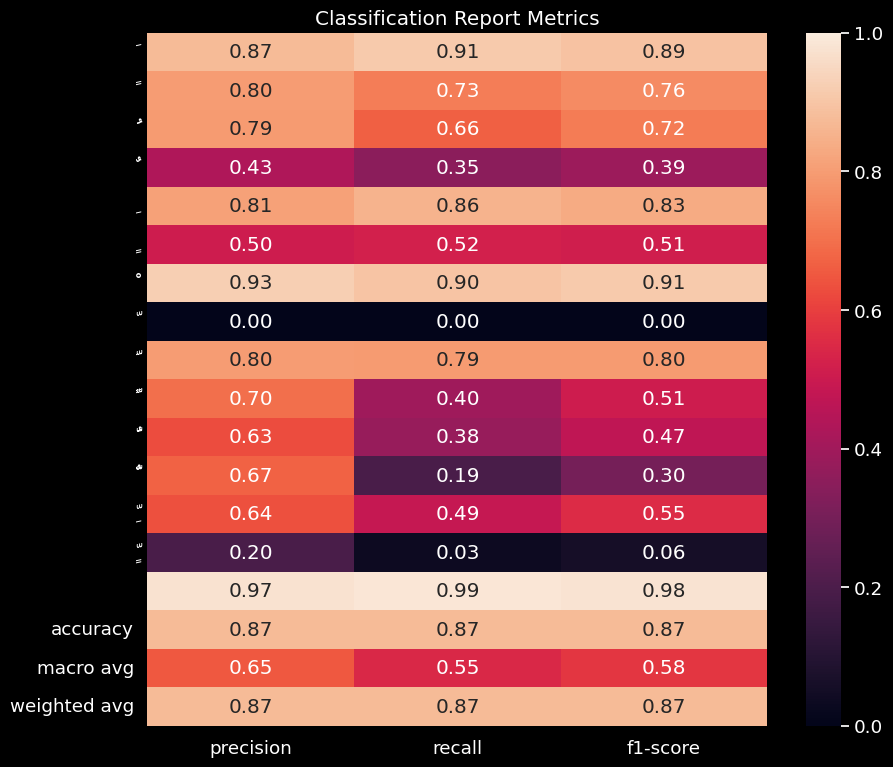

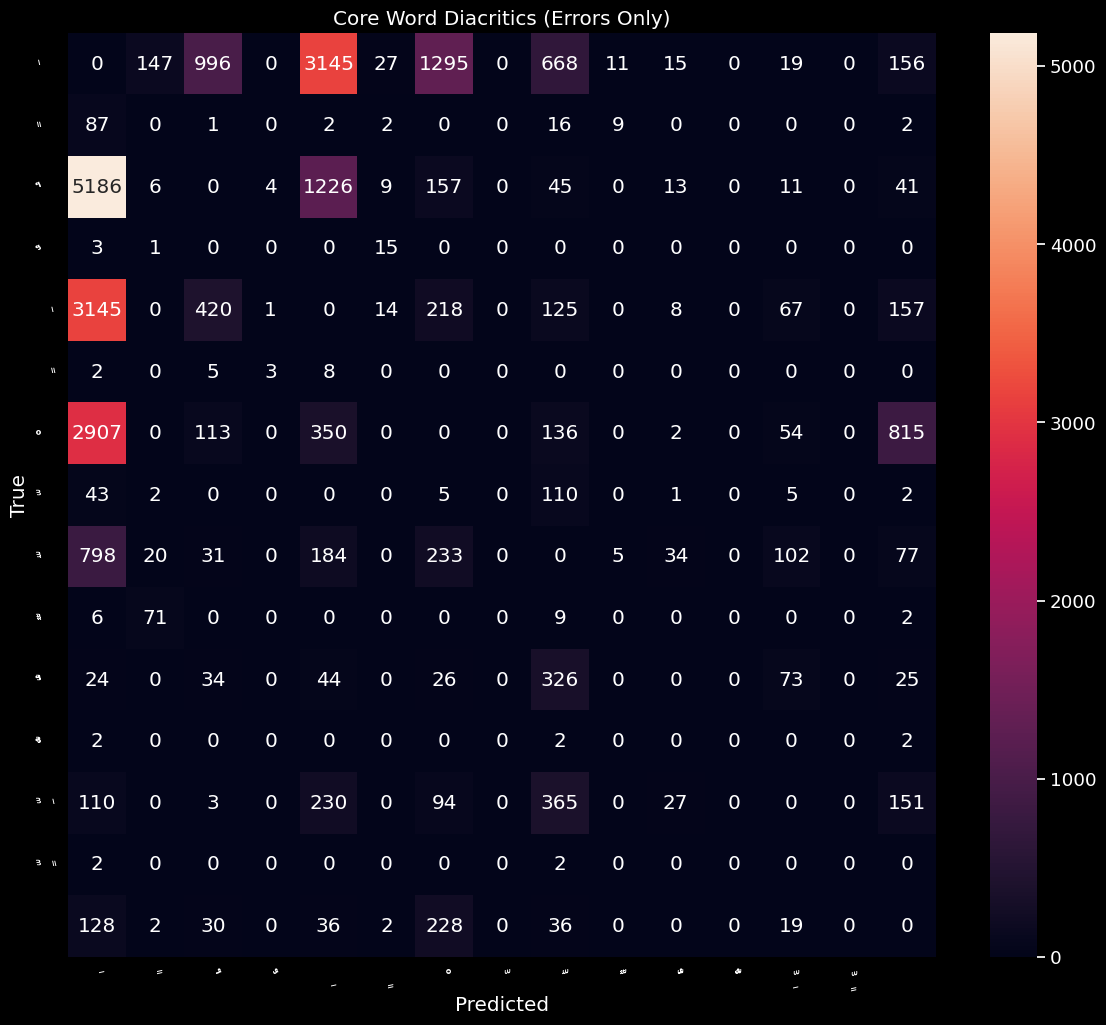

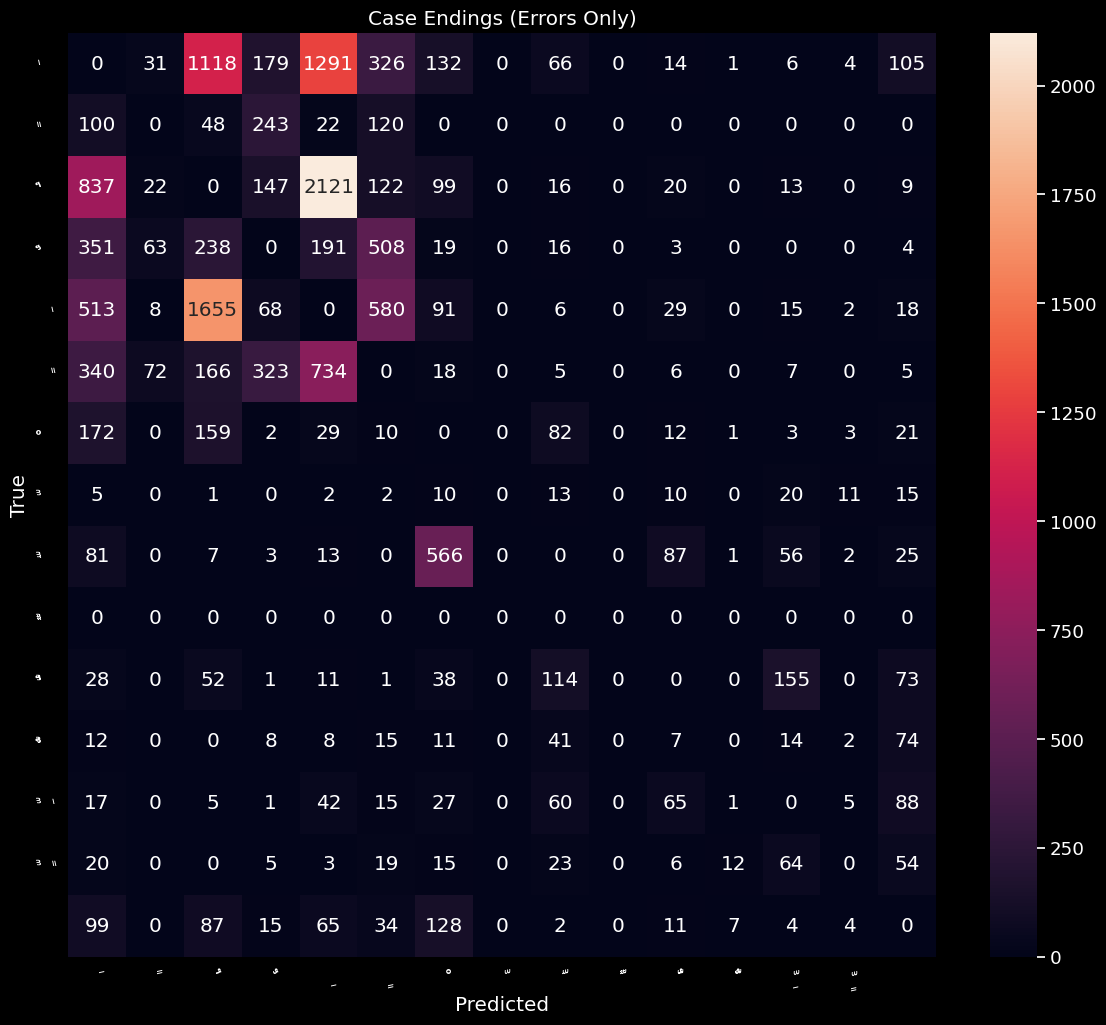


Plots saved to artifacts


In [17]:
# Final Evaluation
# NOTE: Comprehensive evaluation on validation set with visualizations

print("="*50)
print("Final Evaluation on Validation Set")
print("="*50)

val_metrics = calculate_metrics(model, val_loader)

print(f"\nOverall Metrics:")
print(f"  Accuracy: {val_metrics['Accuracy']:.4f}")
print(f"  DER (Diacritic Error Rate): {val_metrics['DER']:.4f}")
print(f"  WER (Word Error Rate): {val_metrics['WER']:.4f}")
print(f"  LCDER (Last Char DER): {val_metrics['LCDER']:.4f}")

# NOTE: Per-class classification report
labels = [ID2DIACRITIC[i] for i in range(len(DIACRITIC2ID))]
print("\nClassification Report:")
print(classification_report(val_metrics['flat_targets_all'], val_metrics['flat_preds_all'], target_names=labels))

# NOTE: Visualize metrics with heatmaps
plot_classification_report(val_metrics['flat_targets_all'], val_metrics['flat_preds_all'], labels, filename="classification_report_final.png")

# NOTE: Separate confusion matrices for core word vs case endings
# Core word diacritics are easier (local patterns), case endings are harder (syntactic)
plot_confusion_matrix(val_metrics['flat_targets_core'], val_metrics['flat_preds_core'], labels, title="Core Word Diacritics", filename="confusion_matrix_core.png")
plot_confusion_matrix(val_metrics['flat_targets_last'], val_metrics['flat_preds_last'], labels, title="Case Endings", filename="confusion_matrix_last.png")

print(f"\nPlots saved to {ARTIFACTS_DIR}")

## Submission Generation

This section generates predictions for the Kaggle test set and formats them for submission.

### Prediction Pipeline:
1. Load test text (undiacritized)
2. Tokenize and convert to model input format
3. Run inference through trained D2 model
4. Align predictions with submission CSV template
5. Save final submission file

In [18]:
# Submission Generation
# NOTE: Generates predictions for Kaggle competition submission

import pandas as pd
import torch
from tqdm import tqdm
from pyarabic.araby import tokenize

def predict_and_save_submission(model, csv_path, txt_path, output_path, word2id, char2id, diacritic2id, device):
    """
    Predicts diacritics for test text and saves submission file.
    
    NOTE: This function handles the alignment between model predictions and 
    the submission CSV format expected by the Kaggle competition.
    
    Args:
        model: Trained D2 model
        csv_path: Path to test CSV template (with letter positions)
        txt_path: Path to undiacritized test text
        output_path: Where to save the submission CSV
        word2id, char2id, diacritic2id: Vocabulary mappings
        device: PyTorch device (cuda/cpu)
    """
    print(f"Loading CSV template from {csv_path}...")
    try:
        df = pd.read_csv(csv_path)
    except Exception as e:
        print(f"Error reading CSV: {e}")
        return

    print(f"Loading text data from {txt_path}...")
    try:
        with open(txt_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
    except Exception as e:
        print(f"Error reading TXT: {e}")
        return

    print("Grouping CSV data by line number...")
    csv_groups = df.groupby('line_number')
    
    model.eval()
    results = {} 
    
    print("Starting prediction...")
    with torch.no_grad():
        for line_idx, line in tqdm(enumerate(lines), total=len(lines), desc="Processing Lines"):
            line = line.strip()
            if not line: continue
            if line_idx not in csv_groups.groups: continue
                
            targets = csv_groups.get_group(line_idx)
            targets_list = list(zip(targets['id'], targets['letter']))
            
            # NOTE: Tokenize line and prepare model inputs
            words = tokenize(line)
            word_ids = []
            char_seqs = []
            line_predictions = []
            
            for word in words:
                chars, _ = extract_chars_and_diacritics(word) 
                undiacritized_word = "".join(chars)
                wid = word2id.get(undiacritized_word, word2id.get("<UNK>", 0))
                word_ids.append(wid)
                cids = [char2id.get(c, char2id.get("<UNK>", 0)) for c in chars]
                char_seqs.append(cids)

            if not word_ids: continue

            # NOTE: Create tensors for model input
            word_ids_tensor = torch.tensor([word_ids], dtype=torch.long).to(device)
            max_Tw = max((len(c) for c in char_seqs), default=0)
            pad_char_id = char2id.get("<PAD>", 0)
            char_seqs_tensor = torch.full((1, len(words), max_Tw), pad_char_id, dtype=torch.long).to(device)
            
            for i, cids in enumerate(char_seqs):
                if len(cids) > 0:
                    char_seqs_tensor[0, i, :len(cids)] = torch.tensor(cids, dtype=torch.long)
            
            try:
                # NOTE: Run inference
                logits = model(word_ids_tensor, char_seqs_tensor)
                preds = torch.argmax(logits, dim=-1)
            except RuntimeError as e:
                print(f"Error predicting line {line_idx}: {e}")
                continue
            
            # NOTE: Collect predictions for all characters in line
            for i, word in enumerate(words):
                chars, _ = extract_chars_and_diacritics(word)
                word_pred_dias = preds[0, i].cpu().numpy()
                for j, char in enumerate(chars):
                    if j < len(word_pred_dias):
                        line_predictions.append((char, word_pred_dias[j]))
            
            # NOTE: Align predictions with CSV targets
            pred_idx = 0
            target_idx = 0
            while pred_idx < len(line_predictions) and target_idx < len(targets_list):
                pred_char, pred_dia = line_predictions[pred_idx]
                target_id, target_char = targets_list[target_idx]
                
                if pred_char == target_char:
                    results[target_id] = pred_dia
                    target_idx += 1
                    pred_idx += 1
                else:
                    pred_idx += 1  # NOTE: Skip non-target chars (punctuation, etc.)
            
            if target_idx < len(targets_list):
                print(f"Warning: Line {line_idx} - Missed {len(targets_list) - target_idx} targets")

    print("Creating submission file...")
    submission_data = []
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Finalizing"):
        row_id = row['id']
        label = results.get(row_id, 0)
        submission_data.append({'id': row_id, 'label': label})
        
    submission_df = pd.DataFrame(submission_data)
    submission_df.to_csv(output_path, index=False)
    print(f"Submission saved to {output_path}")


# NOTE: Run submission generation (only works in Kaggle environment)
if CONFIG["RUNNING_IN_KAGGLE"]:
    predict_and_save_submission(
        model, 
        "/kaggle/input/tashkeel/test_no_diacritics.csv", 
        "/kaggle/input/tashkeel/test_no_diacritics.txt",
        "submission.csv", 
        WORD2ID, 
        CHAR2ID, 
        DIACRITIC2ID, 
        DEVICE
    )
else:
    print("Skipping submission generation (not running in Kaggle mode)")
    print("Set CONFIG['RUNNING_IN_KAGGLE'] = True and provide correct paths to generate submission")

Skipping submission generation (not running in Kaggle mode)
Set CONFIG['RUNNING_IN_KAGGLE'] = True and provide correct paths to generate submission
